In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import collections
import collections.abc

# Backward compatibility for causalgraphicalmodels (expects collections.Iterable)
if not hasattr(collections, "Iterable"):
    collections.Iterable = collections.abc.Iterable

from causalgraphicalmodels import CausalGraphicalModel
import statsmodels.api as sm
from graphviz import Source
from scipy import stats
import os

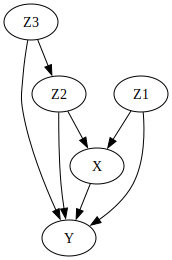

In [10]:

# Create and visualize the DAG
dag = CausalGraphicalModel(
    nodes=['Z3', 'Z1', 'Z2', 'X', 'Y'],
    edges=[
        ('X', 'Y'),      
        ('Z1', 'X'),     
        ('Z1', 'Y'),     
        ('Z2', 'X'),     
        ('Z2', 'Y'),     
        ('Z3', 'Z2'),    
        ('Z3', 'Y')      
    ]
)

# Draw the DAG
Source(dag.draw().source)


In [11]:
output_path = "../output/Graph_the_DAG"
graph = Source(dag.draw().source)
graph.render(filename=output_path, format="png", cleanup=True)

'..\\output\\Graph_the_DAG.png'

### Data Simulation

Following the lab convention where each causal arrow represents a unit effect, we simulate:

- $Z_3 = \varepsilon_{z_3}$
- $Z_1 = \varepsilon_{z_1}$
- $Z_2 = Z_3 + \varepsilon_{z_2}$
- $X = Z_1 + Z_2 + \varepsilon_X$
- $Y = X + Z_1 + Z_2 + Z_3 + \varepsilon_Y$


                 Modelo  Estimacion  Conf. Inferior  Conf. Superior  p-valor
0                 Y ~ X       1.981           1.909           2.052      0.0
1            Y ~ X + Z1       1.976           1.896           2.056      0.0
2            Y ~ X + Z2       1.468           1.387           1.549      0.0
3       Y ~ X + Z1 + Z2       1.000           0.906           1.094      0.0
4  Y ~ X + Z1 + Z2 + Z3       1.016           0.937           1.095      0.0


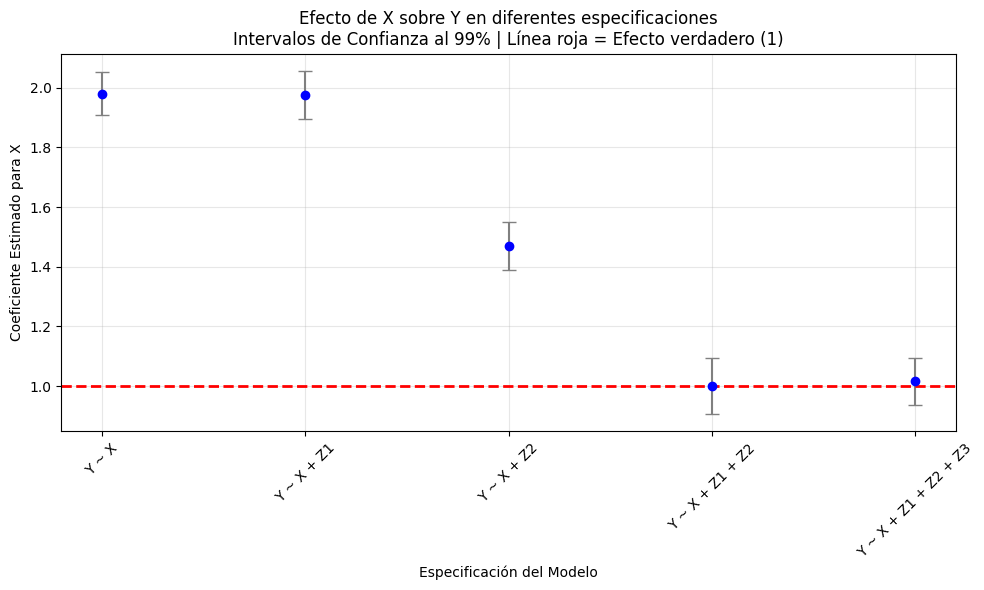

In [ ]:
# === Simular datos ===
n = 1000  # tamaño de muestra

np.random.seed(42)
Z3 = np.random.normal(0, 1, n)                    # exógena
Z1 = np.random.normal(0, 1, n)                    # exógena
Z2 = Z3 + np.random.normal(0, 1, n)               # depende de Z3
X = Z1 + Z2 + np.random.normal(0, 1, n)           # depende de Z1 y Z2
Y = X + Z1 + Z2 + Z3 + np.random.normal(0, 1, n)  # depende de todas

# === Crear DataFrame ===
datos = pd.DataFrame({"Y": Y, "X": X, "Z1": Z1, "Z2": Z2, "Z3": Z3})

# === Definir modelos ===
modelos = [
    "Y ~ X",
    "Y ~ X + Z1",
    "Y ~ X + Z2",
    "Y ~ X + Z1 + Z2",
    "Y ~ X + Z1 + Z2 + Z3"
]

# === Estimar modelos y guardar resultados ===
resultados = []

for formula in modelos:
    model = sm.OLS.from_formula(formula, data=datos).fit()
    coef = model.params["X"]
    conf_int = model.conf_int(alpha=0.01).loc["X"]  # IC al 99%
    p_value = model.pvalues["X"]
    resultados.append({
        "Modelo": formula,
        "Estimacion": coef,
        "Conf. Inferior": conf_int[0],
        "Conf. Superior": conf_int[1],
        "p-valor": p_value
    })

# === Crear DataFrame con resultados ===
resultados_df = pd.DataFrame(resultados)
print(resultados_df.round(3))

# === Graficar ===
plt.figure(figsize=(10, 6))
plt.errorbar(
    x=resultados_df["Modelo"],
    y=resultados_df["Estimacion"],
    yerr=[
        resultados_df["Estimacion"] - resultados_df["Conf. Inferior"],
        resultados_df["Conf. Superior"] - resultados_df["Estimacion"]
    ],
    fmt="o", color="blue", ecolor="gray", capsize=5, markersize=6
)

# Línea roja = efecto verdadero (1)
plt.axhline(y=1, color="red", linestyle="--", linewidth=2)
plt.title("Efecto de X sobre Y en diferentes especificaciones\nIntervalos de Confianza al 99% | Línea roja = Efecto verdadero (1)")
plt.xlabel("Especificación del Modelo")
plt.ylabel("Coeficiente Estimado para X")
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.tight_layout()

# === Guardar gráfico ===
os.makedirs("../output", exist_ok=True)
plt.savefig("../output/efecto_X_sobre_Y.png", dpi=300, bbox_inches="tight", facecolor="white")
plt.show()

In [18]:
# === Comparar modelo 4 y modelo 5 ===

# Reestimar los modelos 4 y 5 (por claridad)
modelo4 = sm.OLS.from_formula("Y ~ X + Z1 + Z2", data=datos).fit()
modelo5 = sm.OLS.from_formula("Y ~ X + Z1 + Z2 + Z3", data=datos).fit()

# Extraer coeficiente, error estándar y R²
coef_4 = modelo4.params["X"]
se_4 = modelo4.bse["X"]
r2_4 = modelo4.rsquared

coef_5 = modelo5.params["X"]
se_5 = modelo5.bse["X"]
r2_5 = modelo5.rsquared



# === Imprimir resultados ===
print("\n" + "="*70)
print("MODELO 4: Y ~ X + Z1 + Z2")
print("="*70)
print(f"- Estimación puntual (X): {coef_4:.4f}")
print(f"- Error estándar:         {se_4:.4f}")
print(f"- R-cuadrado:             {r2_4:.4f}")

print("\n" + "="*70)
print("MODELO 5: Y ~ X + Z1 + Z2 + Z3")
print("="*70)
print(f"- Estimación puntual (X): {coef_5:.4f}")
print(f"- Error estándar:         {se_5:.4f}")
print(f"- R-cuadrado:             {r2_5:.4f}\n")



MODELO 4: Y ~ X + Z1 + Z2
- Estimación puntual (X): 1.0001
- Error estándar:         0.0364
- R-cuadrado:             0.9225

MODELO 5: Y ~ X + Z1 + Z2 + Z3
- Estimación puntual (X): 1.0164
- Error estándar:         0.0306
- R-cuadrado:             0.9452



In [16]:
print(modelo4.summary(1))

                            OLS Regression Results                            
Dep. Variable:                      1   R-squared:                       0.922
Model:                            OLS   Adj. R-squared:                  0.922
Method:                 Least Squares   F-statistic:                     3951.
Date:                Sun, 05 Oct 2025   Prob (F-statistic):               0.00
Time:                        22:59:43   Log-Likelihood:                -1582.8
No. Observations:                1000   AIC:                             3174.
Df Residuals:                     996   BIC:                             3193.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0402      0.037     -1.073      0.2

In [17]:
print(modelo5.summary(1))

                            OLS Regression Results                            
Dep. Variable:                      1   R-squared:                       0.945
Model:                            OLS   Adj. R-squared:                  0.945
Method:                 Least Squares   F-statistic:                     4291.
Date:                Sun, 05 Oct 2025   Prob (F-statistic):               0.00
Time:                        22:59:58   Log-Likelihood:                -1409.3
No. Observations:                1000   AIC:                             2829.
Df Residuals:                     995   BIC:                             2853.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0472      0.031     -1.500      0.1

###  ¿Qué regresiones parecen estimar correctamente el efecto?**

Los modelos que mejor estiman el efecto causal verdadero (β = 1) son los **Modelos 4 y 5**.  
Los primeros modelos (1 a 3) presentan **sesgo por omisión de variables relevantes**, mientras que los Modelos 4 y 5 controlan adecuadamente por los confusores \( Z_1 \) y \( Z_2 \).

**Análisis:**
- **Modelo 1 (Y ~ X):** Coeficiente = 1.981 → fuerte sesgo positivo (≈ +0.98) al omitir \( Z_1, Z_2 \).  
- **Modelo 2 (Y ~ X + Z1):** Coeficiente = 1.976 → sesgo casi igual; \( Z_2 \) sigue ausente.  
- **Modelo 3 (Y ~ X + Z2):** Coeficiente = 1.468 → mejora, pero aún hay sesgo positivo (≈ +0.47).  
- **Modelo 4 (Y ~ X + Z1 + Z2):** Coeficiente = 1.000 → prácticamente insesgado.  
- **Modelo 5 (Y ~ X + Z1 + Z2 + Z3):** Coeficiente = 1.016 → también insesgado; la ligera diferencia se debe al error muestral.

Por tanto, **los Modelos 4 y 5 estiman correctamente el efecto causal de X sobre Y**, al controlar por los verdaderos confusores \( Z_1 \) y \( Z_2 \).

---

###  Tabla resumen de los Modelos (4) y (5) y comentarios sobre estimación y precisión**

| Modelo | Ecuación | Estimación (X) | Error estándar | R² | Comentario |
|:-------|:----------|:---------------|:----------------|:--|:------------|
| 4 | Y ~ X + Z1 + Z2 | **1.0001** | 0.0364 | 0.9225 | Estimación muy cercana al valor verdadero; alta precisión. |
| 5 | Y ~ X + Z1 + Z2 + Z3 | **1.0164** | 0.0306 | 0.9452 | Similar a modelo 4 pero con mayor precisión (menor varianza residual). |

**Interpretación:**
- Ambos modelos capturan correctamente el efecto de \( X \) sobre \( Y \).  
- El **Modelo 5** incluye una variable adicional (\( Z_3 \)), que **no cambia significativamente el coeficiente**, pero **mejora la precisión** (menor error estándar y mayor R²).  
- En otras palabras, **Z₃ no es un confusor**, pero sí ayuda a reducir la varianza no explicada.

---

###  ¿Se puede ignorar alguna de las variables Z₁, Z₂, Z₃ y obtene**

Sí, se puede **ignorar \( Z_3 \)** y aún obtener una buena estimación del efecto de \( X \).  
Las variables críticas para evitar el sesgo son \( Z_1 \) y \( Z_2 \), ya que ambas afectan simultáneamente a \( X \) y \( Y \) (confusores).  

**Explicación causal:**
- \( X \leftarrow Z_1 \rightarrow Y \) → debe bloquearse controlando \( Z_1 \).  
- \( X \leftarrow Z_2 \rightarrow Y \) → debe bloquearse controlando \( Z_2 \).  
- \( Z_3 \) no es confusor; solo influye en \( Y \), no en \( X \).  
Por tanto, controlar \( Z_3 \) **no cambia la identificación causal**, pero sí mejora la eficiencia estadística (reducción del error estándar).

---

### **Conclusión**

- Los **Modelos 4 y 5** estiman correctamente el efecto causal (≈1).  
- El **Modelo 5** presenta **mayor precisión**, aunque la mejora es marginal.  
- Es posible **ignorar \( Z_3 \)** sin introducir sesgo, pero mantenerlo puede ser útil para reducir el error de estimación.

---
